# Data Collection
## Introduction

In [29]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json


from pytz import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta

%matplotlib inline 

print("Library verions:")
print("- numpy:", np.__version__)
print("- pandas:", pd.__version__)
print("- requests:", requests.__version__)
print("- sklearn:", sklearn.__version__)
print("- seaborn:", sns.__version__)

Library verions:
- numpy: 2.2.0
- pandas: 2.3.2
- requests: 2.32.5
- sklearn: 1.7.2
- seaborn: 0.13.2


In [28]:
# Set API key (for traffic data and weather data)
TOMTOM_API_KEY = os.environ.get("TOMTOM_API_KEY")
OPENWEATHER_API_KEY = os.environ.get("OPENWEATHER_API_KEY")
# Coordinates for key locations (latitude, longitude) in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

In [54]:
hcmc_tz = timezone("Asia/Ho_Chi_Minh")

# Set time range for data generation
start_date = datetime(2025, 9, 15, 0, 0, 0, tzinfo=hcmc_tz) 
end_date = datetime(2025, 9, 17, 0, 0, 0, tzinfo=hcmc_tz) # Sep 17, 2025

# Generate list of hourly timestamps
timestamps = []
current_time = start_date
while current_time <= end_date:
    timestamps.append(current_time)
    current_time += timedelta(hours=1)

print("HCMC Timezone:", hcmc_tz)
print("Start date (HCMC):", start_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print("End date (HCMC):", end_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print(f"Collecting data for {len(timestamps)} hourly intervals...")

HCMC Timezone: Asia/Ho_Chi_Minh
Start date (HCMC): 2025-09-15 00:00:00 LMT+0707
End date (HCMC): 2025-09-17 00:00:00 LMT+0707


In [47]:
# 1. Data Requirements
print("Data Requirements for HCMC Traffic Prediction")
data_requirements = {
    'Traffic_Flow': 'Real-time traffic flow data from key locations',
    'Traffic_Speed': 'Average vehicle speed on major roads',
    'Traffic_Congestion': 'Congestion level (0-100%)',
    'Weather_Conditions': 'Current weather conditions (temperature, precipitation, etc.)',
    'Time_Data': 'Timestamp, day of week, hour of day',
    'Location_Data': 'GPS coordinates of traffic monitoring points'
}
for key, value in data_requirements.items():   
    print(f"- {key}: {value}")

Data Requirements for HCMC Traffic Prediction
- Traffic_Flow: Real-time traffic flow data from key locations
- Traffic_Speed: Average vehicle speed on major roads
- Traffic_Congestion: Congestion level (0-100%)
- Weather_Conditions: Current weather conditions (temperature, precipitation, etc.)
- Time_Data: Timestamp, day of week, hour of day
- Location_Data: GPS coordinates of traffic monitoring points


In [ ]:
# 2. Collect the data 
# Function to get traffic data from TomTom API
def get_traffic_data(lat, lon, api_key, timestamp, save_to_file=True):
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    params = {
        'point': f"{lat},{lon}",
        'unit': 'KMPH',
        'key': api_key,
        'zoom': 12
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching traffic data for {lat},{lon} at {timestamp}: {e}")
        return None

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, timestamp, save_to_file=True):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching weather data for {lat},{lon} at {timestamp}: {e}")
        return None


In [55]:
# 3. Process and merge datasets
# Function to process traffic data
def process_traffic_data(traffic_data_dict, location_name, timestamp):
    processed_data = []
    if traffic_data_dict and 'flowSegmentData' in traffic_data_dict:
        segment = traffic_data_dict['flowSegmentData']
        processed_data.append({
            'Location': location_name,
            'Timestamp': timestamp,
            'Current_Speed': segment.get('currentSpeed', 0),
            'Free_Flow_Speed': segment.get('freeFlowSpeed', 0),
            'Confidence': segment.get('confidence', 0),
            'Congestion_Level': segment.get('currentTravelTime', 0) / segment.get('freeFlowTravelTime', 1) * 100,
            'Road_Closure': segment.get('roadClosure', False)
        })
    return processed_data

# Function to process weather data
def process_weather_data(weather_data_dict, timestamp):
    if weather_data_dict and 'main' in weather_data_dict:
        return {
            'Timestamp': timestamp,
            'Temperature': weather_data_dict['main'].get('temp', 0),
            'Humidity': weather_data_dict['main'].get('humidity', 0),
            'Wind_Speed': weather_data_dict['wind'].get('speed', 0) if 'wind' in weather_data_dict else 0,
            'Rainfall': weather_data_dict['rain']['1h'] if 'rain' in weather_data_dict and '1h' in weather_data_dict['rain'] else 0
        }
    return None

# Collect and process data for each hour
all_traffic_data = []
all_weather_data = []

for timestamp in timestamps:
    print(f"\nCollecting data for {timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}...")
    
    # Collect traffic data
    traffic_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching traffic data for {name}...")
        data = get_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY, timestamp)
        if data:
            traffic_data[name] = data
        time.sleep(1)  # Avoid API rate limits
    
    # Collect weather data
    weather_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching weather data for {name}...")
        data = get_weather_data(coords["lat"], coords["lon"], OPENWEATHER_API_KEY, timestamp)
        if data:
            weather_data[name] = data
        time.sleep(1)  # Avoid API rate limits
    
    # Process traffic data
    for name, data in traffic_data.items():
        processed_traffic = process_traffic_data(data, name, timestamp)
        all_traffic_data.extend(processed_traffic)
    
    # Process weather data
    for name, data in weather_data.items():
        processed_weather = process_weather_data(data, timestamp)
        if processed_weather:
            processed_weather['Location'] = name
            all_weather_data.append(processed_weather)

# Create DataFrames
traffic_df = pd.DataFrame(all_traffic_data)
weather_df = pd.DataFrame(all_weather_data)

# Merge datasets on Timestamp and Location
if not traffic_df.empty and not weather_df.empty:
    merged_df = pd.merge(
        traffic_df,
        weather_df,
        on=['Timestamp', 'Location'],
        how='left'
    )
else:
    merged_df = traffic_df if not traffic_df.empty else weather_df

# Add time-based features
if not merged_df.empty:
    merged_df['Hour'] = merged_df['Timestamp'].dt.hour
    merged_df['Month'] = merged_df['Timestamp'].dt.month
    merged_df['Day_of_Week'] = merged_df['Timestamp'].dt.dayofweek
    merged_df['Is_Weekend'] = (merged_df['Day_of_Week'] >= 5).astype(int)
    merged_df['Is_Rush_Hour'] = (
        ((merged_df['Hour'] >= 7) & (merged_df['Hour'] <= 9)) |
        ((merged_df['Hour'] >= 16) & (merged_df['Hour'] <= 19))
    ).astype(int)

# Display the data
print("\nFull Hourly Data:")
print(merged_df.to_string(index=False))



















































Full Hourly Data:
    Location                 Timestamp  Current_Speed  Free_Flow_Speed  Confidence  Congestion_Level  Road_Closure  Temperature  Humidity  Wind_Speed  Rainfall  Hour  Month  Day_of_Week  Is_Weekend  Is_Rush_Hour
  District_1 2025-09-14 23:53:00+07:00             16               26           1        164.516129         False        27.77        87        4.12         0    23      9            6           1             0
   Thu_Thiem 2025-09-14 23:53:00+07:00             40               40           1        100.000000         False        27.83        87        4.12         0    23      9            6           1             0
Tan_Son_Nhat 2025-09-14 23:53:00+07:00             31               31           1        100.000000         False        27.01       100        4.12         0    23      9            6           1             0
  Binh_Thanh 2025-09-14 23:53:00+07:00             15               34           1  

In [61]:
traffic_df.head(20)

,Location,Timestamp,Current_Speed,Free_Flow_Speed,Confidence,Congestion_Level,Road_Closure
0,District_1,2025-09-14 23:53:00+07:00,16,26,1,164.516129,False
1,Thu_Thiem,2025-09-14 23:53:00+07:00,40,40,1,100.000000,False
2,Tan_Son_Nhat,2025-09-14 23:53:00+07:00,31,31,1,100.000000,False
3,Binh_Thanh,2025-09-14 23:53:00+07:00,15,34,1,227.748691,False
4,Phu_My_Hung,2025-09-14 23:53:00+07:00,42,42,1,100.000000,False
5,District_1,2025-09-15 00:53:00+07:00,16,25,1,154.545455,False
6,Thu_Thiem,2025-09-15 00:53:00+07:00,40,40,1,100.000000,False
7,Tan_Son_Nhat,2025-09-15 00:53:00+07:00,31,31,1,100.000000,False
8,Binh_Thanh,2025-09-15 00:53:00+07:00,15,32,1,214.285714,False
9,Phu_My_Hung,2025-09-15 00:53:00+07:00,42,42,1,100.000000,False


In [62]:
weather_df.head(20) 

,Timestamp,Temperature,Humidity,Wind_Speed,Rainfall,Location
0,2025-09-14 23:53:00+07:00,27.77,87,4.12,0,District_1
1,2025-09-14 23:53:00+07:00,27.83,87,4.12,0,Thu_Thiem
2,2025-09-14 23:53:00+07:00,27.01,100,4.12,0,Tan_Son_Nhat
3,2025-09-14 23:53:00+07:00,27.83,87,4.12,0,Binh_Thanh
4,2025-09-14 23:53:00+07:00,27.84,87,4.12,0,Phu_My_Hung
5,2025-09-15 00:53:00+07:00,27.77,87,4.12,0,District_1
6,2025-09-15 00:53:00+07:00,27.83,87,4.12,0,Thu_Thiem
7,2025-09-15 00:53:00+07:00,27.01,100,4.12,0,Tan_Son_Nhat
8,2025-09-15 00:53:00+07:00,27.83,87,4.12,0,Binh_Thanh
9,2025-09-15 00:53:00+07:00,27.84,87,4.12,0,Phu_My_Hung


In [ ]:
# 4. Where to store your collected data
print("Saving processed data to CSV...")
merged_df.to_csv('hcmc_traffic_weather_data.csv', index=False)
print("\nData saved to 'hcmc_traffic_weather_data.csv'")

Saving processed data to CSV...

Data saved to 'hcmc_traffic_weather_data.csv'


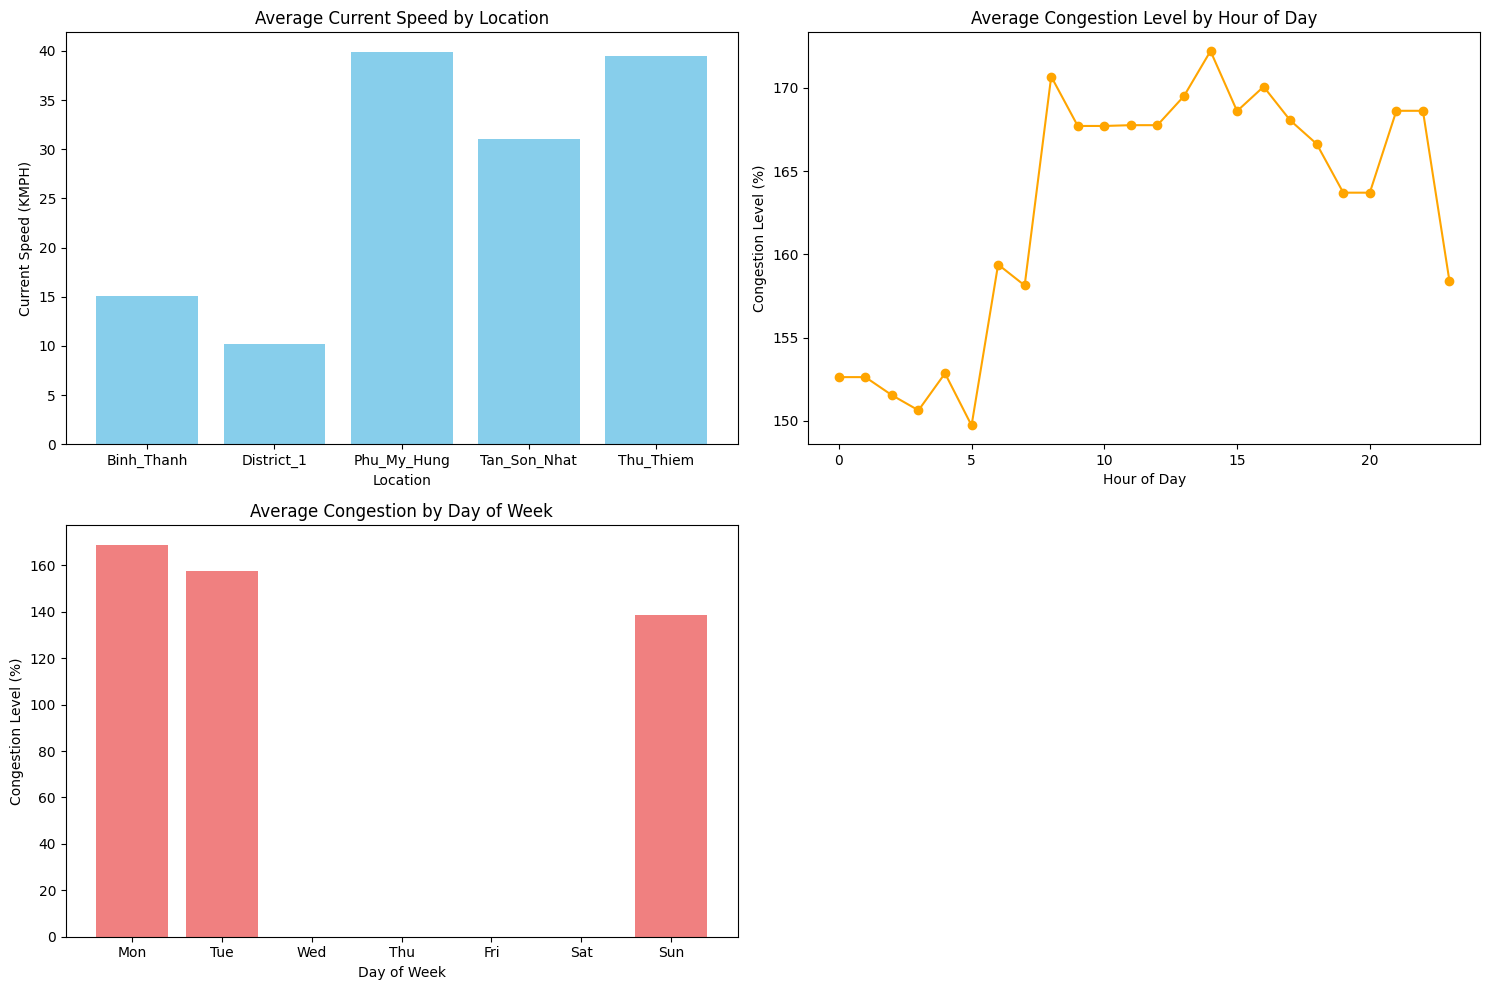

In [58]:
# 5. Visualize the traffic data
plt.figure(figsize=(15, 10))

# Plot 1: Average Current Speed by Location
plt.subplot(2, 2, 1)
avg_speed_by_location = merged_df.groupby('Location')['Current_Speed'].mean()
plt.bar(avg_speed_by_location.index, avg_speed_by_location.values, color='skyblue')
plt.title('Average Current Speed by Location')
plt.xlabel('Location')
plt.ylabel('Current Speed (KMPH)')  

# Plot 2: Congestion level by hour of day 
plt.subplot(2, 2, 2)
hourly_congestion = merged_df.groupby('Hour')['Congestion_Level'].mean()
plt.plot(hourly_congestion.index, hourly_congestion.values, marker='o', color='orange')
plt.title('Average Congestion Level by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Congestion Level (%)')

# Plot 3: Day vs Congestion Level
plt.subplot(2, 2, 3)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_congestion = merged_df.groupby('Day_of_Week')['Congestion_Level'].mean()
plt.bar(daily_congestion.index, daily_congestion.values, color='lightcoral')
plt.title('Average Congestion by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Congestion Level (%)')
plt.xticks(range(7), days)

plt.tight_layout()
plt.show()


In [52]:
# 7. Modeling with Linear Regression and KNN
print("Preparing data for traffic prediction modeling...")

# prepare features and target variable
features = ['Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Temperature', 'Humidity', 'Congestion_Level', 'Wind_Speed']
target = 'Current_Speed'

X = merged_df[features]
y = merged_df[target]

# Check for missing values
print("Missing values in features:")
print(X.isnull().sum())
print("Missing values in target:")
print(y.isnull().sum())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Preparing data for traffic prediction modeling...
Missing values in features:
Hour                0
Day_of_Week         0
Is_Weekend          0
Is_Rush_Hour        0
Temperature         0
Humidity            0
Congestion_Level    0
Wind_Speed          0
dtype: int64
Missing values in target:
0


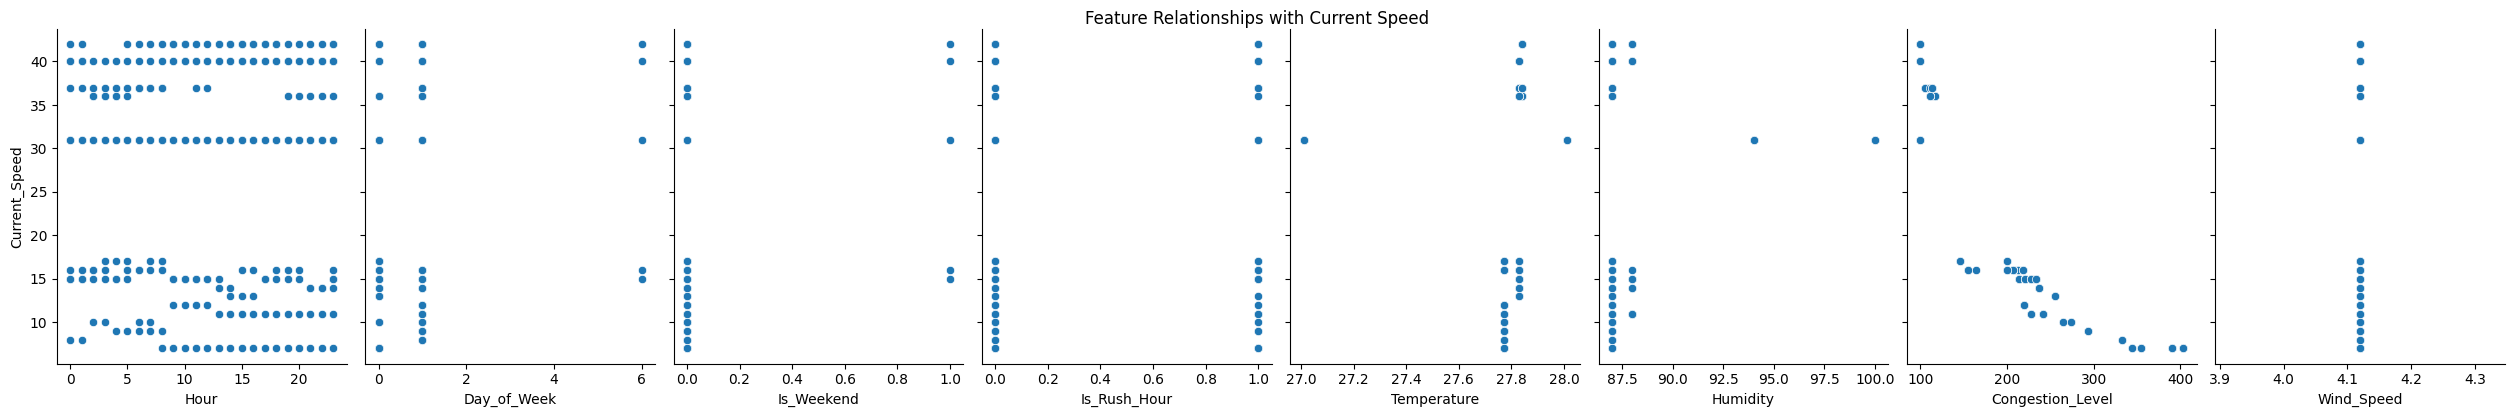

KNN Model Evaluation Metrics:
Mean Squared Error: 33.44
Mean Absolute Error: 3.03
R2 Score: 0.73


In [59]:
# Scaling model for KNN
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plot = sns.pairplot(merged_df, x_vars=features, y_vars=target, height=4, aspect=0.8)
plt.suptitle('Feature Relationships with Current Speed', y=1.02)
plt.show()

# Modelling for KNN
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"KNN Model Evaluation Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


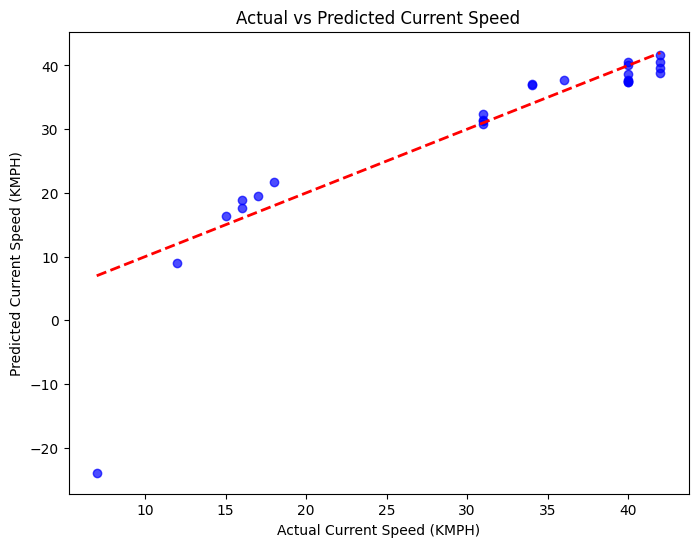

Model Evaluation Metrics:
Mean Squared Error: 42.63


In [60]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Draw scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Current Speed (KMPH)')
plt.ylabel('Predicted Current Speed (KMPH)')
plt.title('Actual vs Predicted Current Speed')
plt.show()
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Model Evaluation Metrics:")
print(f"Mean Squared Error: {mse:.2f}")



In [ ]:
# 8. Data Dictionary
print("Creating data dictionary...")

data_dict = {
    'Data Element Name': [
        'Location', 'Timestamp', 'Current_Speed', 'Free_Flow_Speed', 
        'Congestion_Level', 'Confidence', 'Road_Closure', 'Temperature',
        'Humidity', 'Pressure', 'Weather_Description', 'Wind_Speed',
        'Rainfall', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour'
    ],
    'Data Type': [
        'Categorical', 'DateTime', 'Numeric', 'Numeric', 'Numeric', 
        'Numeric', 'Boolean', 'Numeric', 'Numeric', 'Numeric', 
        'Categorical', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 
        'Boolean', 'Boolean'
    ],
    'Units': [
        'Text', 'DateTime', 'km/h', 'km/h', 'Percentage', 
        'Percentage', 'Boolean', '°C', '%', 'hPa', 
        'Text', 'm/s', 'mm', 'Hour (0-23)', 'Day (0-6)', 
        'Boolean', 'Boolean'
    ],
    'Range/Description': [
        'District names in HCMC', 'Date and time of measurement', 
        'Current traffic speed (5-80 km/h)', 'Free flow speed under ideal conditions',
        'Congestion level (0-200%)', 'Data confidence level (0-100%)',
        'Whether road is closed', 'Temperature in Celsius',
        'Relative humidity', 'Atmospheric pressure', 
        'Description of weather conditions', 'Wind speed',
        'Rainfall in last hour', 'Hour of day (0-23)', 
        'Day of week (0=Monday, 6=Sunday)', 'Whether it is weekend',
        'Whether it is rush hour (7-9 AM, 4-7 PM)'
    ],
    'Source': [
        'Predefined locations', 'API timestamp', 'TomTom API', 'TomTom API',
        'Calculated (CurrentTravelTime/FreeFlowTravelTime)', 'TomTom API',
        'TomTom API', 'OpenWeatherMap API', 'OpenWeatherMap API', 
        'OpenWeatherMap API', 'OpenWeatherMap API', 'OpenWeatherMap API',
        'OpenWeatherMap API', 'Derived from Timestamp', 'Derived from Timestamp',
        'Derived from Day_of_Week', 'Derived from Hour'
    ]
}

data_dict_df = pd.DataFrame(data_dict)
print("Data Dictionary:")
print(data_dict_df.to_string(index=False))

# 9. Save final dataset and model
print("Saving final dataset and model information...")
final_df.to_csv('hcmc_traffic_final_dataset.csv', index=False)

Creating data dictionary...
Data Dictionary:
  Data Element Name   Data Type       Units                        Range/Description                                            Source
           Location Categorical        Text                   District names in HCMC                              Predefined locations
          Timestamp    DateTime    DateTime             Date and time of measurement                                     API timestamp
      Current_Speed     Numeric        km/h        Current traffic speed (5-80 km/h)                                        TomTom API
    Free_Flow_Speed     Numeric        km/h   Free flow speed under ideal conditions                                        TomTom API
   Congestion_Level     Numeric  Percentage                Congestion level (0-200%) Calculated (CurrentTravelTime/FreeFlowTravelTime)
         Confidence     Numeric  Percentage           Data confidence level (0-100%)                                        TomTom API
       Roa